In [2]:
import pandas as pd
import os
import ast
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

data_dir = '../data/annotated/'

/Users/alexfroitzheim/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def parse_annotation(anno):
    if anno.startswith("LABEL: "):
        anno = anno[7:]

    if anno.startswith("SUPPORTED"):
        ev = anno.split('\n')[1]
        ev = ev.split(':')[0]

        ev_idx = [int(p.strip()) - 1 for p in ev.split(',')]

        return ("SUPPORTS", ev_idx)
    
    elif anno.startswith("REFUTED"):
        if len(anno.split('\n')) != 2:
            return ("REFUTES", [])
        
        else:
            ev = anno.split('\n')[1]

            if ev.startswith("There is no") or ev.startswith("This claim") or ev.startswith("The evidence text"):
                return ("REFUTES", [])
            
            elif ev.startswith("Sentence 1"):
                return ("REFUTES", [0])

            else:
                ev_idx = [int(p.strip()) for p in ev.split(',')]
                return ("REFUTES", ev_idx)
            
    elif anno.startswith("NOT ENOUGH INFO"):
        return ("NOT ENOUGH INFO", [])
    
    else:
        raise ValueError(f"Cannot parse annotation: {anno}")
    

def get_evidence_correctness(row):

    if row['label'] == 'NOT ENOUGH INFO' or row['gpt_label'] == 'NOT ENOUGH INFO':
        return ''

    pred_ev = row['gpt_evidence']
    gold_ev = row['compressed_evidence']

    if type(gold_ev) == str:
        gold_ev = ast.literal_eval(gold_ev)

    if type(pred_ev) == str:
        pred_ev = ast.literal_eval(pred_ev)

    if len(pred_ev) == 0:
        return 'NOTHING'

    if pred_ev in gold_ev:
        return 'CORRECT'
    
    ev_labels = []
    pred_ev = set(pred_ev)

    for alt in gold_ev:
        alt = set(alt)
        if pred_ev.issubset(alt):
            ev_labels.append('SUBSET')
        elif pred_ev.issuperset(alt):
            ev_labels.append('SUPERSET')
        elif len(pred_ev.intersection(alt)) > 0:
            ev_labels.append('OVERLAP')
        else:
            ev_labels.append('DISJOINT')

    ev_labels = list(set(ev_labels))

    if len(ev_labels) == 1:
        return ev_labels[0]
    
    if len(ev_labels) == 2 and 'DISJOINT' in ev_labels:
        ev_labels.remove('DISJOINT')
        return ev_labels[0]
    
    else:
        return ev_labels

In [4]:
dfs = []

for file in os.listdir(data_dir):
    if(file == '.DS_Store'):
        continue
    df = pd.read_csv(data_dir + file, sep=';', index_col=0)
    dfs.append(df)

# Concatenate all dataframes
df = pd.concat(dfs, ignore_index=True).reset_index(drop=True)

# Add columns to df: gpt_label is parse_annotation[0], gpt_evidence is parse_annotation[1]
df['gpt_label'] = df['annotation'].apply(lambda x: parse_annotation(x)[0])
df['gpt_evidence'] = df['annotation'].apply(lambda x: parse_annotation(x)[1])

df['evidence_correctness'] = df.apply(get_evidence_correctness, axis=1)

## Label Correctness

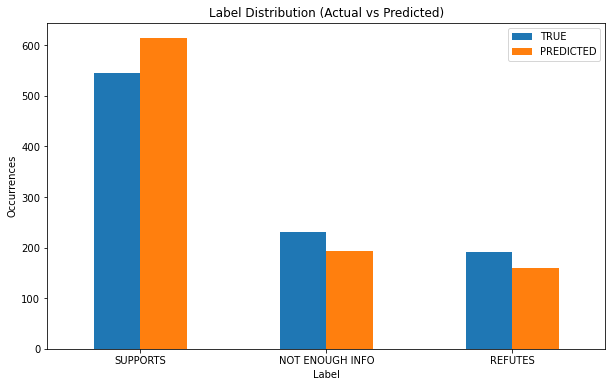

                 precision    recall  f1-score   support

NOT ENOUGH INFO       0.52      0.43      0.47       230
        REFUTES       0.52      0.43      0.47       191
       SUPPORTS       0.76      0.86      0.80       545

       accuracy                           0.67       966
      macro avg       0.60      0.57      0.58       966
   weighted avg       0.65      0.67      0.66       966



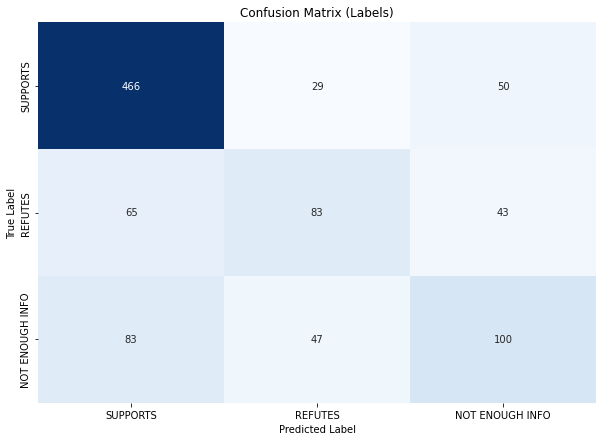

In [5]:
true_labels = df['label']
predicted_labels = df['gpt_label']

true_counts = true_labels.value_counts()
pred_counts = predicted_labels.value_counts()

plot_data = pd.DataFrame({
    'TRUE': true_counts,
    'PREDICTED': pred_counts,
}).fillna(0)  # Fill NaN values with 0

plot_data.plot(kind='bar', figsize=(10, 6))
plt.title('Label Distribution (Actual vs Predicted)')
plt.xlabel('Label')
plt.ylabel('Occurrences')
plt.xticks(rotation=0)  # Assuming binary values (True/False)
plt.show()

# Precision, Recall, F1-Score for each class
class_report = classification_report(true_labels, predicted_labels)
print(class_report)

labels = ['SUPPORTS', 'REFUTES', 'NOT ENOUGH INFO']

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)

# Adding the aesthetics
plt.title('Confusion Matrix (Labels)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Show the plot
plt.show()


## Evidence Correctness

Accuracy (Completely correct): 0.36
Accuracy (Correct or more): 0.5
Accuracy (Any correct sentence): 0.51


/var/folders/mm/xlpsvlm130vdqz7c99mnfj800000gn/T/ipykernel_56915/3077311959.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_ts = df[df['label'] == 'SUPPORTS'][df['gpt_label'] == 'SUPPORTS']
/var/folders/mm/xlpsvlm130vdqz7c99mnfj800000gn/T/ipykernel_56915/3077311959.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_fs = df[df['label'] == 'REFUTES'][df['gpt_label'] == 'SUPPORTS']
/var/folders/mm/xlpsvlm130vdqz7c99mnfj800000gn/T/ipykernel_56915/3077311959.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tr = df[df['label'] == 'REFUTES'][df['gpt_label'] == 'REFUTES']
/var/folders/mm/xlpsvlm130vdqz7c99mnfj800000gn/T/ipykernel_56915/3077311959.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_fr = df[df['label'] == 'SUPPORTS'][df['gpt_label'] == 'REFUTES']


,TRUE SUPPORTS,FALSE SUPPORTS,TRUE REFUTES,FALSE REFUTES
CORRECT,198.0,27.0,5.0,0.0
SUPERSET,75.0,6.0,10.0,3.0
OVERLAP,1.0,0.0,0.0,0.0
SUBSET,4.0,0.0,0.0,0.0
DISJOINT,188.0,32.0,49.0,24.0
NOTHING,0.0,0.0,19.0,2.0


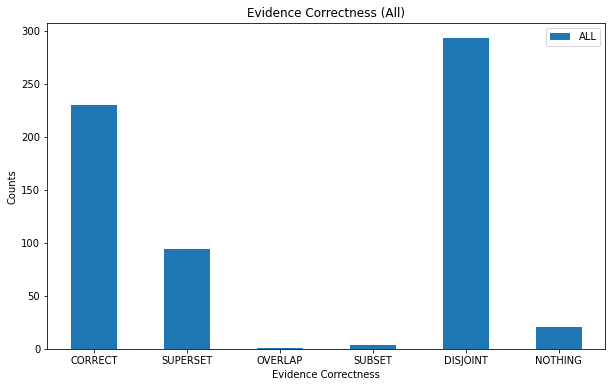

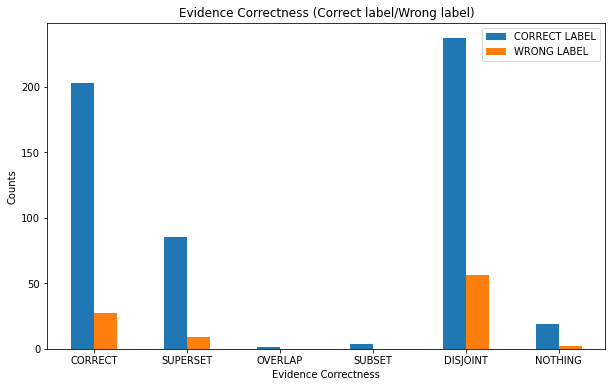

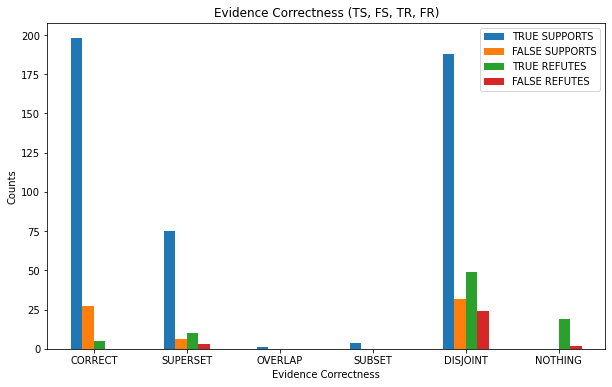

In [6]:
df_ts = df[df['label'] == 'SUPPORTS'][df['gpt_label'] == 'SUPPORTS']
df_fs = df[df['label'] == 'REFUTES'][df['gpt_label'] == 'SUPPORTS']
df_tr = df[df['label'] == 'REFUTES'][df['gpt_label'] == 'REFUTES']
df_fr = df[df['label'] == 'SUPPORTS'][df['gpt_label'] == 'REFUTES']

df_t = pd.concat([df_ts, df_tr])
df_f = pd.concat([df_fs, df_fr])
df_tf = pd.concat([df_t, df_f])

ts_counts = df_ts['evidence_correctness'].value_counts()
fs_counts = df_fs['evidence_correctness'].value_counts()
tr_counts = df_tr['evidence_correctness'].value_counts()
fr_counts = df_fr['evidence_correctness'].value_counts()

t_counts = df_t['evidence_correctness'].value_counts()
f_counts = df_f['evidence_correctness'].value_counts()

tf_counts = df_tf['evidence_correctness'].value_counts()

total = tf_counts.sum()
correct = tf_counts['CORRECT']
correct_superset = correct + tf_counts['SUPERSET']
correct_any = correct_superset + tf_counts['SUBSET'] + tf_counts['OVERLAP']

accuracy_correct = correct / total
accuracy_correct_superset = correct_superset / total
accuracy_correct_any = correct_any / total

print(f"Accuracy (Completely correct): {round(accuracy_correct, 2)}")
print(f"Accuracy (Correct or more): {round(accuracy_correct_superset, 2)}")
print(f"Accuracy (Any correct sentence): {round(accuracy_correct_any, 2)}")

labels = ['CORRECT', 'SUPERSET', 'OVERLAP', 'SUBSET', 'DISJOINT', 'NOTHING']

evidence_correctness_confusion = pd.DataFrame({
    'TRUE SUPPORTS': ts_counts,
    'FALSE SUPPORTS': fs_counts,
    'TRUE REFUTES': tr_counts,
    'FALSE REFUTES': fr_counts,
}).fillna(0).reindex(labels)

evidence_correctness_truefalse = pd.DataFrame({
    'CORRECT LABEL': t_counts,
    'WRONG LABEL': f_counts,
}).fillna(0).reindex(labels)

evidence_correctness_all = pd.DataFrame({
    'ALL': tf_counts
}).fillna(0).reindex(labels)

evidence_correctness_all.plot(kind='bar', figsize=(10, 6))
plt.title('Evidence Correctness (All)')
plt.xlabel('Evidence Correctness')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.show()

evidence_correctness_truefalse.plot(kind='bar', figsize=(10, 6))
plt.title('Evidence Correctness (Correct label/Wrong label)')
plt.xlabel('Evidence Correctness')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.show()

evidence_correctness_confusion.plot(kind='bar', figsize=(10, 6))
plt.title('Evidence Correctness (TS, FS, TR, FR)')
plt.xlabel('Evidence Correctness')
plt.ylabel('Counts')
plt.xticks(rotation=0)
plt.show()

## Joint Correctness

/var/folders/mm/xlpsvlm130vdqz7c99mnfj800000gn/T/ipykernel_56915/3266162830.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  both_correct_strict = len(df[df['label_correct'] == True][(df['evidence_correct_strict'] == True) | (df['label'] == 'NOT ENOUGH INFO')])
/var/folders/mm/xlpsvlm130vdqz7c99mnfj800000gn/T/ipykernel_56915/3266162830.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  only_label_correct_strict = len(df[df['label_correct'] == True][(df['evidence_correct_strict'] == False) & (df['label'] != 'NOT ENOUGH INFO')])
/var/folders/mm/xlpsvlm130vdqz7c99mnfj800000gn/T/ipykernel_56915/3266162830.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  only_evidence_correct_strict = len(df[df['label_correct'] == False][(df['evidence_correct_strict'] == True) & (df['label'] != 'NOT ENOUGH INFO')])
/var/folders/mm/xlpsvlm130vdqz7c99mnfj800000gn/T/ipykernel_56915/3266162830.py:10: UserWarni

,Strict,Medium,Relaxed
Both correct,303,388,393
Only label correct,346,261,256
Only evidence correct,27,36,36
Both wrong,290,281,281


,Strict,Medium,Relaxed
Both correct,31.37 %,40.17 %,40.68 %
Only label correct,35.82 %,27.02 %,26.50 %
Only evidence correct,2.80 %,3.73 %,3.73 %
Both wrong,30.02 %,29.09 %,29.09 %


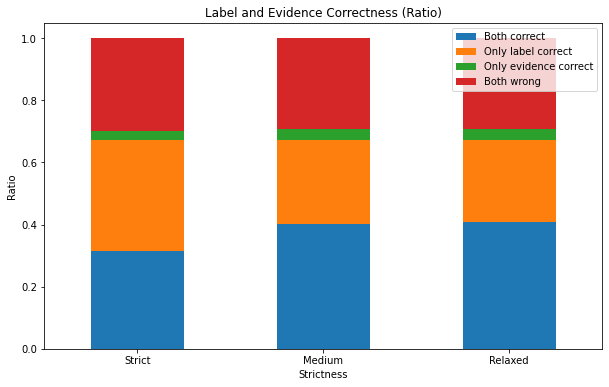

In [10]:
df['label_correct'] = df['label'] == df['gpt_label']
df['evidence_correct_strict'] = df['evidence_correctness'] == 'CORRECT'
df['evidence_correct_medium'] = df['evidence_correctness'].isin(['CORRECT', 'SUPERSET'])
df['evidence_correct_relaxed'] = df['evidence_correctness'].isin(['CORRECT', 'SUPERSET', 'OVERLAP', 'SUBSET'])

# Both correct, only label correct, only evidence correct, both wrong (Strict)
both_correct_strict = len(df[df['label_correct'] == True][(df['evidence_correct_strict'] == True) | (df['label'] == 'NOT ENOUGH INFO')])
only_label_correct_strict = len(df[df['label_correct'] == True][(df['evidence_correct_strict'] == False) & (df['label'] != 'NOT ENOUGH INFO')])
only_evidence_correct_strict = len(df[df['label_correct'] == False][(df['evidence_correct_strict'] == True) & (df['label'] != 'NOT ENOUGH INFO')])
both_wrong_strict = len(df[df['label_correct'] == False][(df['evidence_correct_strict'] == False) | (df['label'] == 'NOT ENOUGH INFO')])

# Both correct, only label correct, only evidence correct, both wrong (Medium)
both_correct_medium = len(df[df['label_correct'] == True][(df['evidence_correct_medium'] == True) | (df['label'] == 'NOT ENOUGH INFO')])
only_label_correct_medium = len(df[df['label_correct'] == True][(df['evidence_correct_medium'] == False) & (df['label'] != 'NOT ENOUGH INFO')])
only_evidence_correct_medium = len(df[df['label_correct'] == False][(df['evidence_correct_medium'] == True) & (df['label'] != 'NOT ENOUGH INFO')])
both_wrong_medium = len(df[df['label_correct'] == False][(df['evidence_correct_medium'] == False) | (df['label'] == 'NOT ENOUGH INFO')])


# Both correct, only label correct, only evidence correct, both wrong (Relaxed)
both_correct_relaxed = len(df[df['label_correct'] == True][(df['evidence_correct_relaxed'] == True) | (df['label'] == 'NOT ENOUGH INFO')])
only_label_correct_relaxed = len(df[df['label_correct'] == True][(df['evidence_correct_relaxed'] == False) & (df['label'] != 'NOT ENOUGH INFO')])
only_evidence_correct_relaxed = len(df[df['label_correct'] == False][(df['evidence_correct_relaxed'] == True) & (df['label'] != 'NOT ENOUGH INFO')])
both_wrong_relaxed = len(df[df['label_correct'] == False][(df['evidence_correct_relaxed'] == False) | (df['label'] == 'NOT ENOUGH INFO')])

joint_correctness_df = pd.DataFrame({
    'Strict': [both_correct_strict, only_label_correct_strict, only_evidence_correct_strict, both_wrong_strict],
    'Medium': [both_correct_medium, only_label_correct_medium, only_evidence_correct_medium, both_wrong_medium],
    'Relaxed': [both_correct_relaxed, only_label_correct_relaxed, only_evidence_correct_relaxed, both_wrong_relaxed],
}, index=['Both correct', 'Only label correct', 'Only evidence correct', 'Both wrong'])


# Get another df with column percentages
joint_correctness_ratio_df = joint_correctness_df / joint_correctness_df.sum(axis=0)

display(joint_correctness_df)

pd.options.display.float_format = '{:,.2f} %'.format
display(joint_correctness_ratio_df * 100)


joint_correctness_ratio_df.transpose().plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Strictness')
plt.xticks(rotation=0)
plt.ylabel('Ratio')
plt.title('Label and Evidence Correctness (Ratio)')
plt.show()


In [7]:
error_analysis_fs = df_fs.head()
error_analysis_fr = df_fr.head()

error_analysis_fr.to_csv('../data/error_analysis_fr.csv', sep=';')
error_analysis_fs.to_csv('../data/error_analysis_fs.csv', sep=';')

In [11]:
df.to_csv('../results/annotated_dataset.csv', sep=';', index=False)